In [1]:
# Import Dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Normalization, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization

# DATA PREPARATION

In [2]:
# Load Malaria Dataset From Tensorflow Datasets
dataset, datasetInfo = tfds.load("malaria", 
                                 with_info=True, 
                                 shuffle_files=True) # -----------++++++    ->    ---+++-++--+++-

2025-01-18 22:45:04.565907: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-01-18 22:45:04.565935: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-01-18 22:45:04.565939: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-01-18 22:45:04.565953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-18 22:45:04.565964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Dataset Descriptions
print(dataset)
# 0 -> Parasitic
# 1 -> Non-Parasitic
print(len(dataset))

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}
1


In [4]:
# Dataset Split Function
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    trainDataset = dataset.take(int(TRAIN_RATIO*len(dataset)))
    leftDataset = dataset.skip(int(TRAIN_RATIO*len(dataset)))
    valDataset = leftDataset.take(int(VAL_RATIO*len(dataset)))
    testDataset = leftDataset.skip(int(VAL_RATIO*len(dataset)))
    return trainDataset, valDataset, testDataset

In [5]:
# Split Dataset As 80/10/10 
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
trainDataset, valDataset, testDataset = split(dataset['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(len(trainDataset))
print(len(valDataset))
print(len(testDataset))

22046
2755
2757


# DATA VISUALIZATION

In [6]:
# Function To Extract Labels From Output
def getLabel(label):
    if label==0:
        return "Parasitized"
    return "Unparasitized"

2025-01-18 22:45:04.689803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


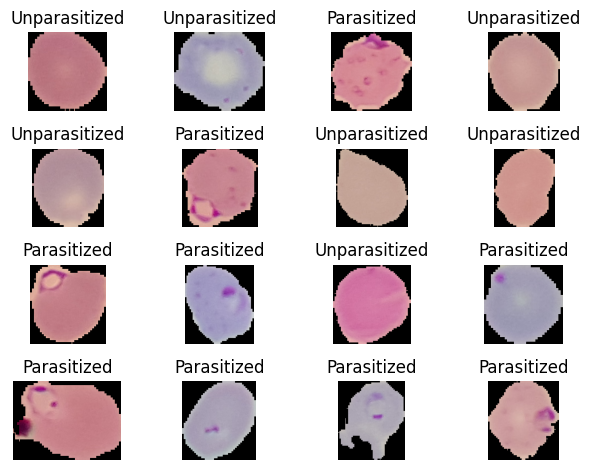

In [7]:
# Plotting Images From Each Class
for i, sample in enumerate(trainDataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(sample['image'])
    plt.title(getLabel(sample['label']))
    plt.axis("off")
plt.tight_layout()
plt.show()

# DATA PROCESSING

In [8]:
# Resizing Images To Same Shapes For Model &
# Normalize Image : Pixel Values / 255 -> Range(0, 1)
IMAGE_SIZE = 224
def resizeRescale(inputs):
    return tf.image.resize(inputs['image'], (IMAGE_SIZE, IMAGE_SIZE))/255., inputs['label']
trainDataset = trainDataset.map(resizeRescale)
valDataset = valDataset.map(resizeRescale)
testDataset = testDataset.map(resizeRescale)

In [9]:
# Dataset Batching
BATCH_SIZE=32
BUFFER_SIZE = 8
trainDataset = trainDataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valDataset = valDataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
testDataset = testDataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
# Checking The Processed Data
for image, label in trainDataset:
    print(image.shape)
    print(image, label)
    print(np.unique(image))
    break

(32, 224, 224, 3)
tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0

# DATA MODELING -> Convolutional Neural Network

In [15]:
# Using Sequential API
model = tf.keras.Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

# ERROR SANCTIONING -> Binary Crossentropy Loss

## BCE = -y.log(yp) - (1-y).log(1-yp)

In [16]:
# JUST AN EXAMPLE FOR EXPLANATION : NOT A PART OF CURRENT PROJECT
# BCE Example
yTrue = tf.constant([1, 0, 1, 1])
yPred = tf.constant([1, 1, 1, 1])
bce = tf.keras.losses.BinaryCrossentropy()
print(bce(yTrue, yPred))

tf.Tensor(3.9855962, shape=(), dtype=float32)


In [17]:
# Compile Model With BCE Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# MODEL TRAINING & OPTIMIZATION

In [18]:
# Train The Model
with tf.device(":/GPU"):
    history = model.fit(
    trainDataset,
    validation_data=valDataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - binary_accuracy: 0.6665 - loss: 0.6211 - val_binary_accuracy: 0.5575 - val_loss: 1.4663
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - binary_accuracy: 0.8987 - loss: 0.3215 - val_binary_accuracy: 0.9405 - val_loss: 0.2739
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - binary_accuracy: 0.9200 - loss: 0.2620 - val_binary_accuracy: 0.9481 - val_loss: 0.2070
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - binary_accuracy: 0.9290 - loss: 0.2350 - val_binary_accuracy: 0.9379 - val_loss: 0.2007
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - binary_accuracy: 0.9314 - loss: 0.2350 - val_binary_accuracy: 0.9379 - val_loss: 0.2135
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - binary_accuracy: 0.9333 - loss: 0.2240 - val_binary_accuracy: 0.9441 - val_loss: 0.2271
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - binary_accuracy: 0.9303 - loss: 0.2315 - val_binary_accuracy: 0.9314 - val_loss:

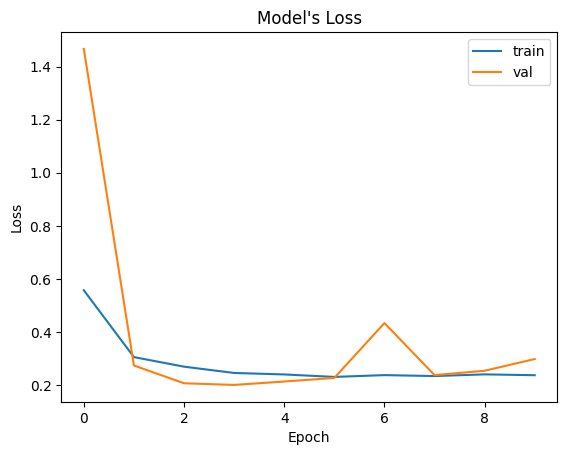

In [19]:
# PLotting the model's loss graph for both training and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "val"])
plt.show()

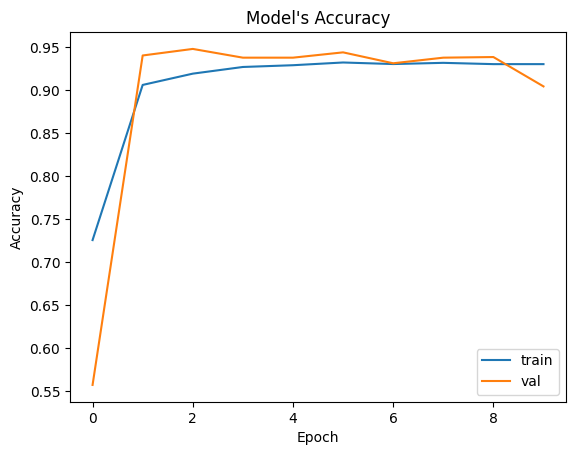

In [20]:
# PLotting the model's accuracy graph for both training and validation
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title("Model's Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"])
plt.show()

# EVALUATION & TESTING

In [21]:
# Model Evaluate
model.evaluate(testDataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - binary_accuracy: 0.9057 - loss: 0.3012


[0.3164793848991394, 0.899891197681427]

In [36]:
# Prediction Function
def parasiteOrNot(x):
    if x<0.5:
        return str('P')
    return str("U")

In [37]:
prediction = model.predict(testDataset.take(1))[0][0]
print(parasiteOrNot(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
P


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2025-01-18 22:57:39.056446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


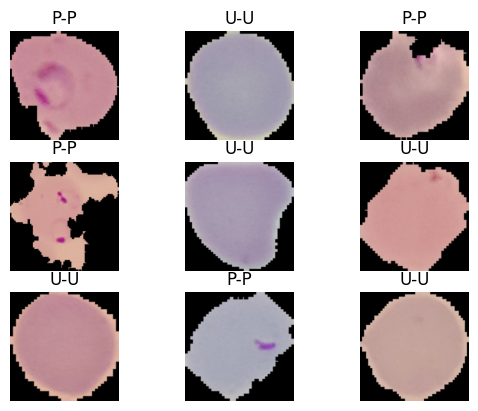

In [39]:
# Visualizing Model's Performance
for image, label in testDataset.take(1):
    predictions = model.predict(image)
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i])
        plt.title(parasiteOrNot(label.numpy()[i]) + "-" + parasiteOrNot(predictions[i][0]))
        plt.axis("off")
plt.show()

# SAVING & LOADING TENSORFLOW MODELS

## Option 1 : Save Both Model's Configuration(Structure & Hyperparameters) and Weights 
### -> When We Don't Know The Model's Configuration Upfront
## Option 2 : Save Only The Model's Weights

#### OPTION 1 : Configuration + Weights

In [71]:
# Saving The Model Using .keras
model.save("/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Convolutional-Neural-Network/Models/LeNetModel.keras")

In [72]:
# Loading The Saved Model
loadedModelKeras = tf.keras.models.load_model("/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Convolutional-Neural-Network/Models/LeNetModel.keras")
loadedModelKeras.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/ComputerVision/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,336,332 (35.62 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 4,668,035 (17.81 MB)

In [73]:
# Saving The Model Using > .hdf5 (Lower Version of .keras) -> Can't be used for custom layers
model.save("/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Convolutional-Neural-Network/Models/LeNetModel.hdf5")

In [74]:
# Loading The Saved Model
loadedModelHdf5 = tf.keras.models.load_model("/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Convolutional-Neural-Network/Models/LeNetModel.hdf5")
loadedModelHdf5.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,299 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 2 (12.00 B)

#### OPTION 2 : Only Weights

In [80]:
# Saving Model Weights
model.save_weights("/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Convolutional-Neural-Network/Weights/LeNetModelWeights.weights.h5")

In [86]:
# Loading The Weights
model.load_weights("/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Convolutional-Neural-Network/Weights/LeNetModelWeights.weights.h5")